### 최종적으로 미측정값 scale_pv = 0에 대한 데이터 증강 실시 
### 증강 방법은 KNN <hr>

### 데이터 및 모듈 로딩 <hr>

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

In [134]:
file = '../data/mydata2_final.csv'
data = pd.read_csv(file)
data

,c_temp_pv,k_rpm_pv,n_temp_pv,scale_pv,s_temp_pv
0,69.6,189,67.2,3.01,67.1
1,69.8,189,67.2,3.01,67.0
2,69.7,189,67.9,3.08,65.9
3,69.7,189,67.8,3.08,65.9
4,69.7,189,67.8,3.08,65.9
...,...,...,...,...,...
193963,69.6,184,66.5,0.00,67.6
193964,69.5,184,66.6,0.00,67.7
193965,69.4,184,66.5,0.00,67.7
193966,69.4,184,66.4,0.00,67.8


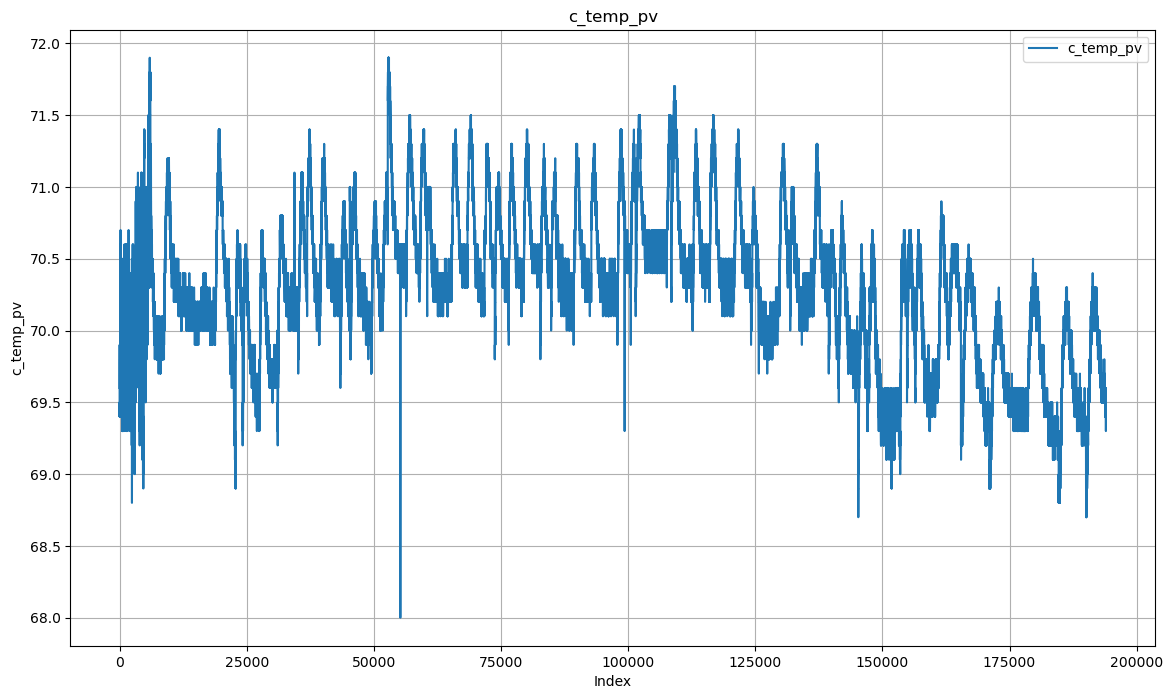

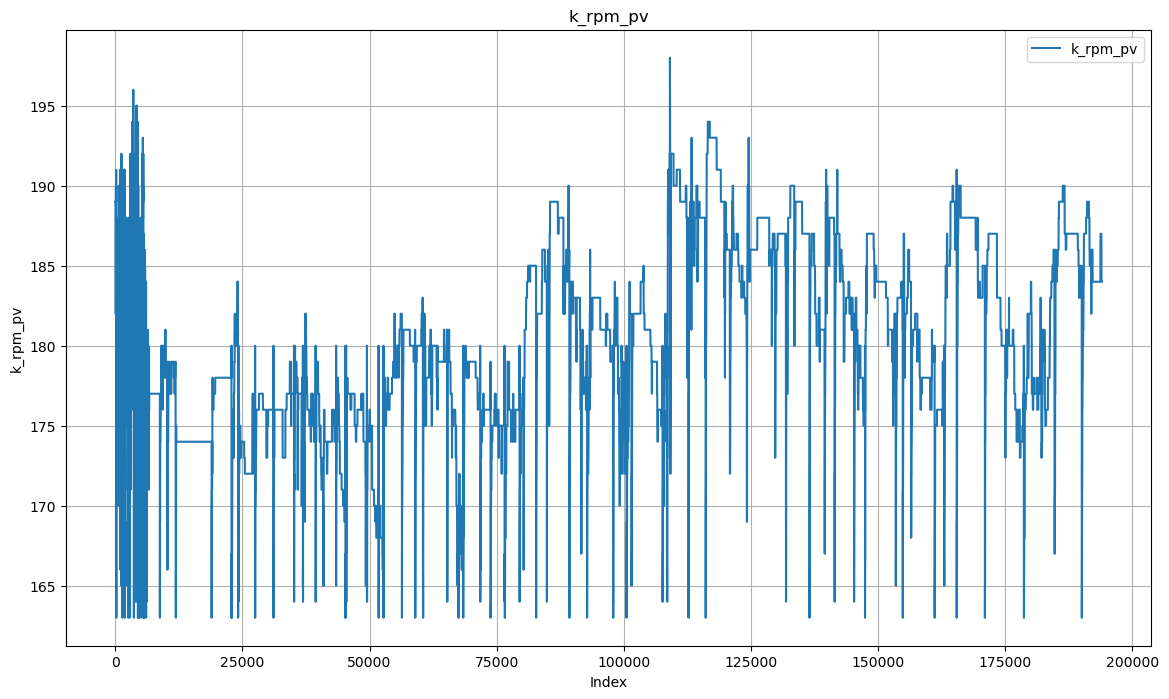

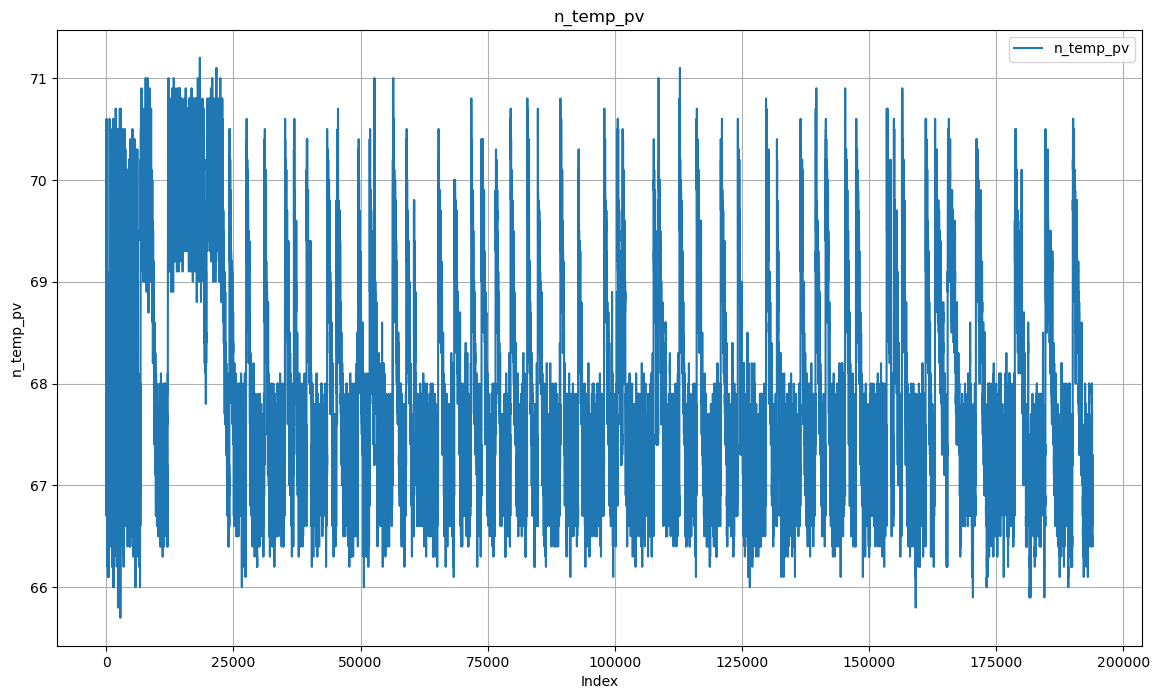

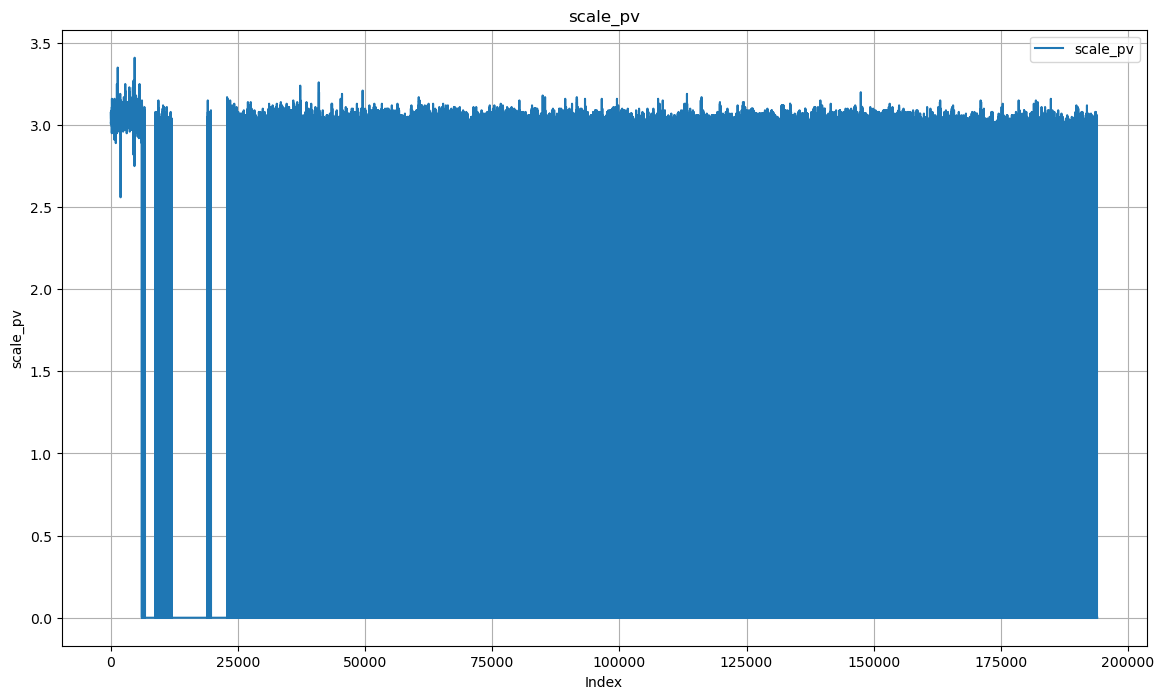

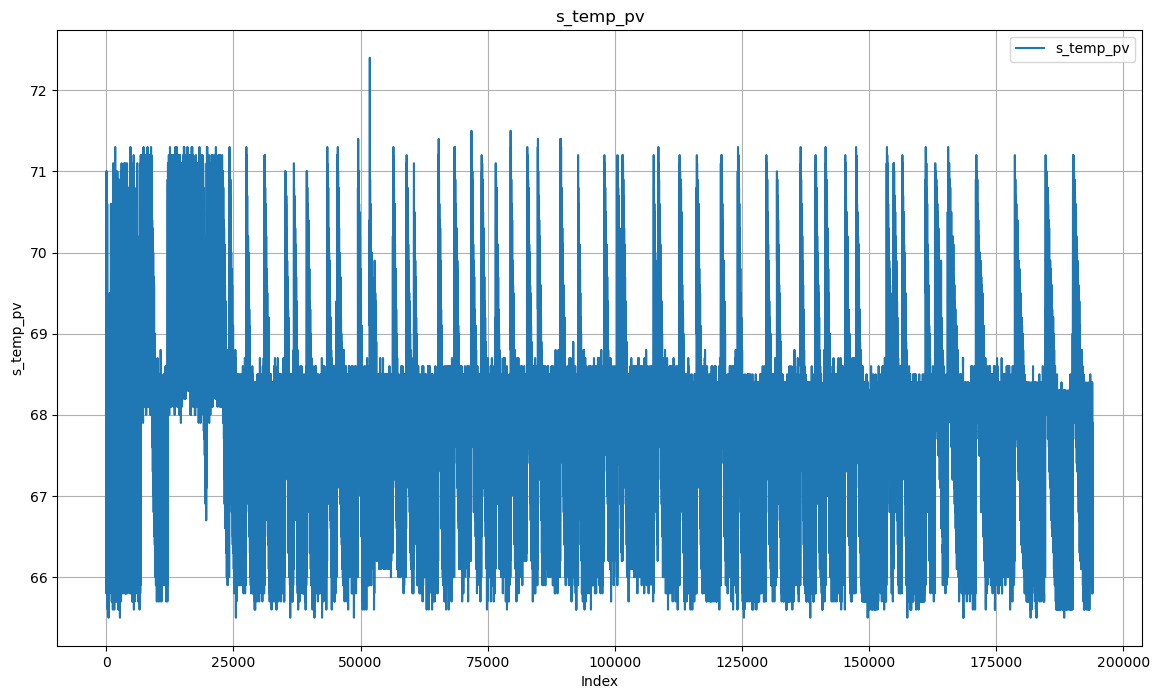

In [135]:
# 각 컬럼별 그래프 그리기
for column in data.columns:
    plt.figure(figsize=(14, 8))
    plt.plot(data.index, data[column], label=column)
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.title(f'{column}')
    plt.legend()
    plt.grid(True)
    plt.show()

C:\Users\KDP\AppData\Local\Temp\ipykernel_17172\3247075966.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_data.loc[:, 'scale_pv'] = predicted_scale_pv


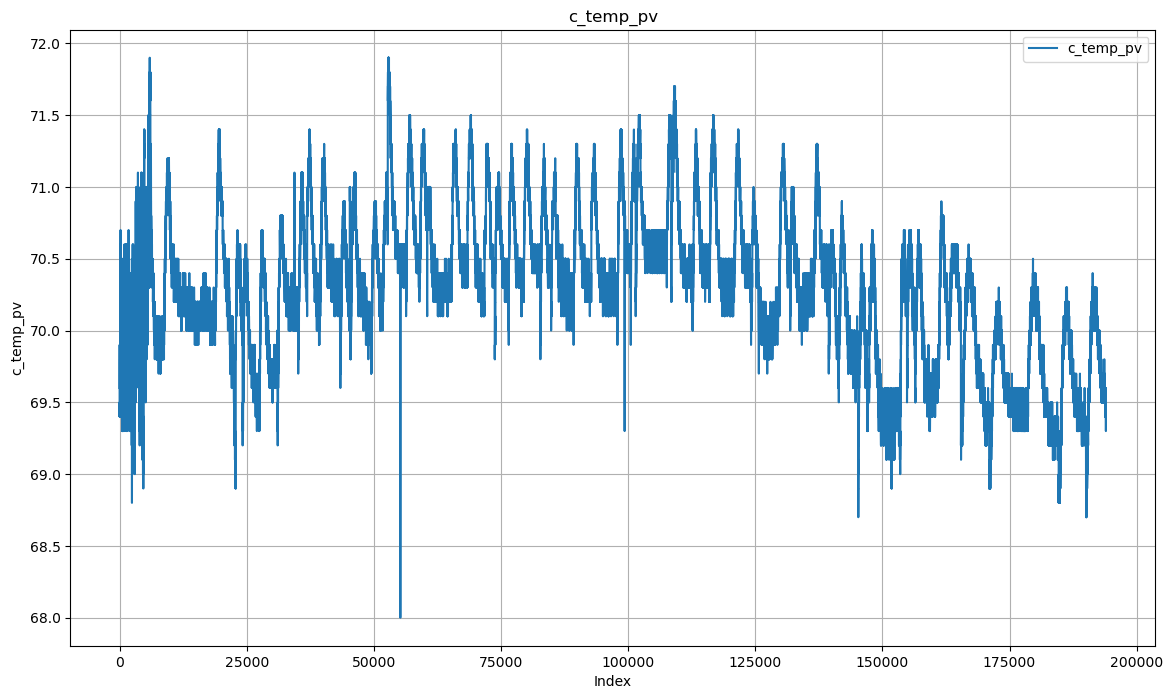

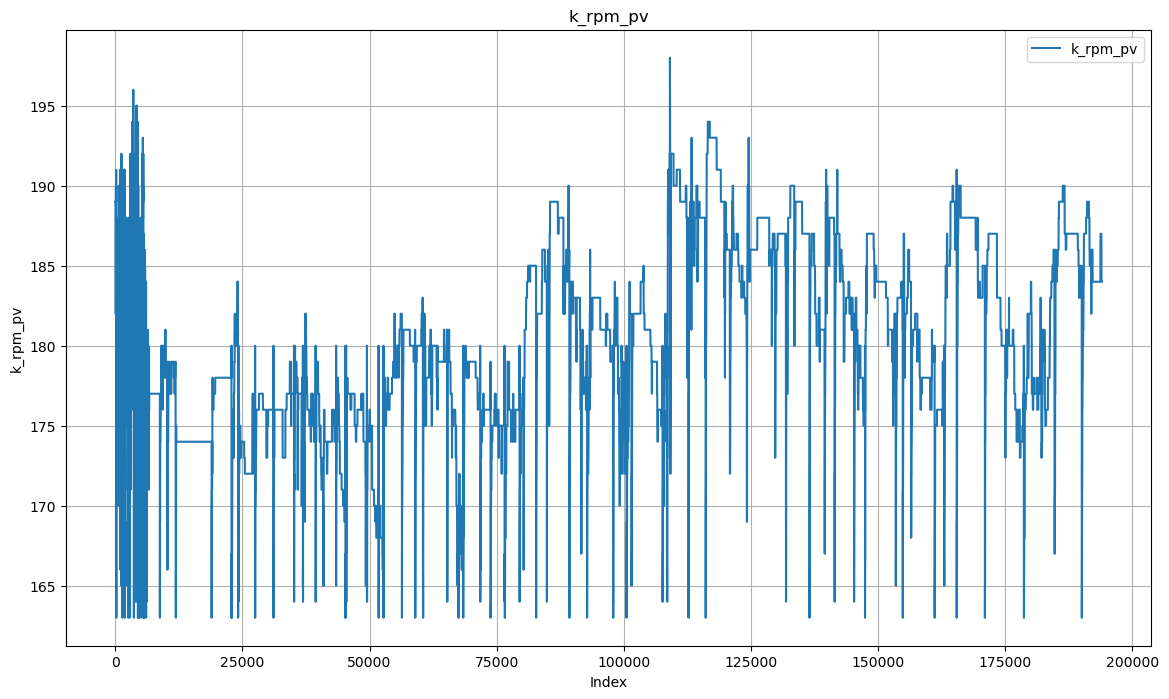

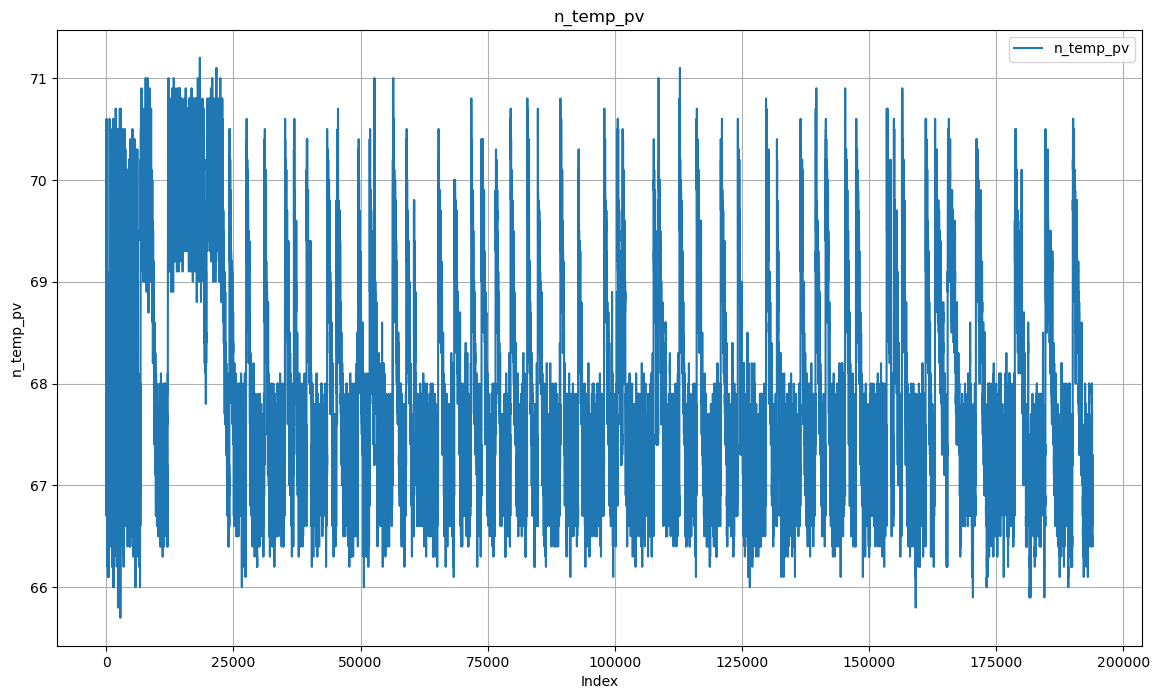

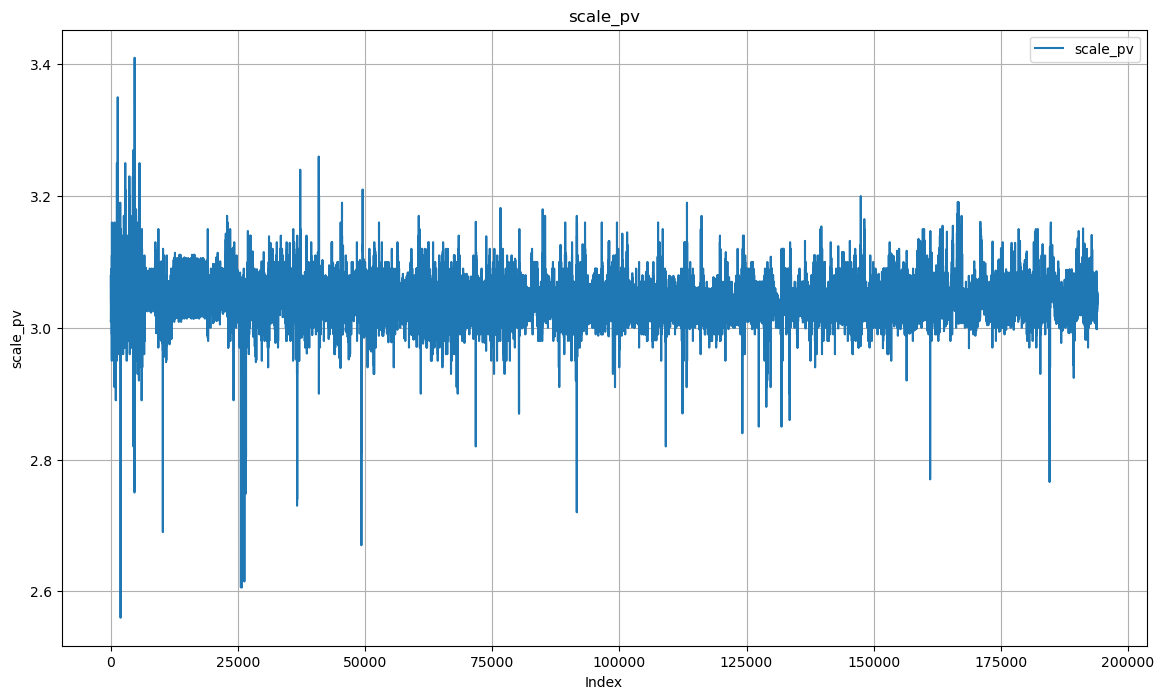

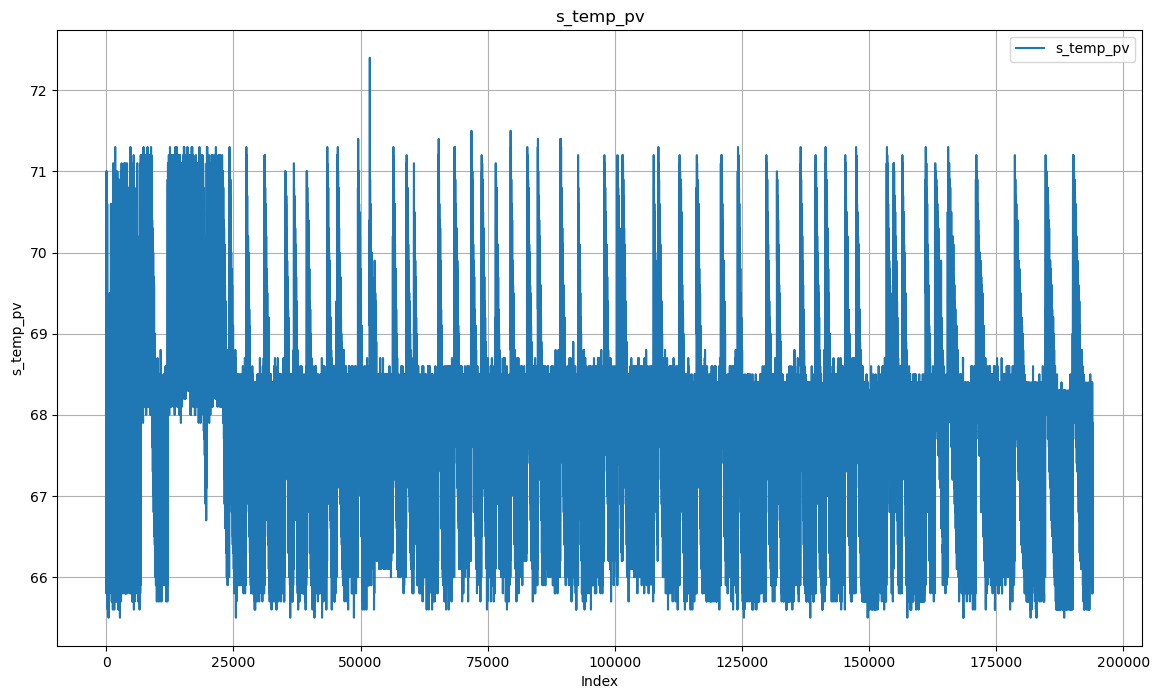

In [136]:
# scale_pv가 0이 아닌 데이터와 0인 데이터로 분리
non_zero_data = data[data['scale_pv'] != 0]
zero_data = data[data['scale_pv'] == 0]

# KNN을 위한 피처와 타겟 설정 (scale_pv가 0이 아닌 데이터)
features = non_zero_data.drop(columns=['scale_pv'])
target = non_zero_data['scale_pv']

# 데이터 스케일링
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_zero_features = scaler.transform(zero_data.drop(columns=['scale_pv']))

# KNN 모델 적합
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(scaled_features, target)

# 미측정 데이터에 대한 예측값 생성 (scale_pv가 0인 데이터)
predicted_scale_pv = knn.predict(scaled_zero_features)

# 예측값을 미측정 데이터에 추가
zero_data.loc[:, 'scale_pv'] = predicted_scale_pv

# 원본 데이터와 새로 생성된 데이터를 결합하여 인덱스 기준으로 재정렬
augmented_data = pd.concat([non_zero_data, zero_data]).sort_index()

# augmented_data를 원래 데이터의 순서로 재정렬
augmented_data = augmented_data.loc[data.index]


# 각 컬럼별 그래프 그리기
for column in augmented_data.columns:
    plt.figure(figsize=(14, 8))
    plt.plot(augmented_data.index, augmented_data[column], label=column)
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.title(f'{column}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [137]:
# 데이터의 순서가 유지되었는지 확인
original_order = data.index
augmented_order = augmented_data.index

# 순서가 같은지 비교
order_is_same = np.array_equal(original_order, augmented_order)

print("Original and augmented data order is the same:", order_is_same)

# 중복값 제거
augmented_data.drop_duplicates(inplace=True)

Original and augmented data order is the same: True


In [138]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [139]:
# 피처와 타겟 분리
X = augmented_data.drop(columns=['scale_pv'])
y = augmented_data['scale_pv']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습 및 평가 함수
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    return train_mae, test_mae, train_mape, test_mape

# Multiple Regression
lr_model = LinearRegression()
lr_train_mae, lr_test_mae, lr_train_mape, lr_test_mape = train_and_evaluate_model(lr_model, X_train, X_test, y_train, y_test)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_train_mae, rf_test_mae, rf_train_mape, rf_test_mape = train_and_evaluate_model(rf_model, X_train, X_test, y_train, y_test)

# LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_train_mae, lgb_test_mae, lgb_train_mape, lgb_test_mape = train_and_evaluate_model(lgb_model, X_train, X_test, y_train, y_test)

# 결과 출력
print(f"Linear Regression - Train MAE: {lr_train_mae}, Train MAPE: {lr_train_mape*100}")
print(f"Linear Regression - Test MAE: {lr_test_mae}, Test MAPE: {lr_test_mape*100}")
print(f"Random Forest - Train MAE: {rf_train_mae}, Train MAPE: {rf_train_mape*100}")
print(f"Random Forest - Test MAE: {rf_test_mae}, Test MAPE: {rf_test_mape*100}")
print(f"LightGBM - Train MAE: {lgb_train_mae}, Train MAPE: {lgb_train_mape*100}")
print(f"LightGBM - Test MAE: {lgb_test_mae}, Test MAPE: {lgb_test_mape*100}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 103004, number of used features: 4
[LightGBM] [Info] Start training from score 3.042988
Linear Regression - Train MAE: 0.016352312690594176, Train MAPE: 0.5382495993686909
Linear Regression - Test MAE: 0.016208812246223538, Test MAPE: 0.5331446765679201
Random Forest - Train MAE: 0.004874821603503175, Train MAPE: 0.16043582648702295
Random Forest - Test MAE: 0.01041136783045733, Test MAPE: 0.3424130128123581
LightGBM - Train MAE: 0.013775227543178272, Train MAPE: 0.4531148211415734
LightGBM - Test MAE: 0.013866895823907299, Test MAPE: 0.45592046650684825
